## CRYPTOCURRENCY PRICE ANALYSIS

## Scraping Using API which scrape's every 2hours

In [1]:
import requests
import pandas as pd
import os
import time
import datetime

def fetch_all_crypto_data(csv_file="all_crypto_data.csv"):
    API_URL = "https://api.coingecko.com/api/v3/coins/markets"
    PER_PAGE = 250
    PAGE = 1
    PARAMS = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': PER_PAGE,
        'page': PAGE,
        'sparkline': False
    }

    all_records = []
    timestamp = datetime.datetime.now()

    while True:
        PARAMS['page'] = PAGE
        response = requests.get(API_URL, params=PARAMS)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()
        if not data:
            break  # Exit if no more data

        for coin in data:
            all_records.append({
                "name": coin['name'],
                "price": coin['current_price'],
                "market_cap": coin['market_cap'],
                "volume_24h": coin['total_volume'],
                "circulating_supply": coin['circulating_supply'],
                "timestamp": timestamp
            })

        PAGE += 1

    df_new = pd.DataFrame(all_records)

    if os.path.exists(csv_file):
        df_old = pd.read_csv(csv_file)
        last_snapshot = df_old[df_old['timestamp'] == df_old['timestamp'].max()]
        merged = pd.merge(df_new, last_snapshot[['name', 'price']], on='name', how='left', suffixes=('', '_2hrs_ago'))
        merged['change_2hrs'] = merged['price'] - merged['price_2hrs_ago']
        merged.drop(columns=['price_2hrs_ago'], inplace=True)
    else:
        merged = df_new.copy()
        merged['change_2hrs'] = None

    merged.to_csv(csv_file, mode='a', index=False, header=not os.path.exists(csv_file))
    print(f"[{timestamp}] Fetched {len(df_new)} coins and saved to {csv_file}.")

# Continuous Loop
if __name__ == "__main__":
    try:
        while True:
            fetch_all_crypto_data()
            print("Sleeping for 2 hours...\n")
            time.sleep(7200)  # Sleep for 2 hours
    except KeyboardInterrupt:
        print("Stopped by user.")


Error: 429
[2025-08-03 05:46:22.574104] Fetched 1250 coins and saved to all_crypto_data.csv.
Sleeping for 2 hours...

Stopped by user.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
##  Loading DataSet
csv_path = 'all_crypto_data.csv'


df = pd.read_csv(csv_path, parse_dates=['timestamp'], low_memory=False)
df.head()


,name,price,market_cap,volume_24h,circulating_supply,timestamp,change_2hrs
0,Bitcoin,117851.000000,2344824322422,4.006794e+10,1.989927e+07,2025-07-30T05:26:03.208943,NaN
1,Ethereum,3798.330000,458326758616,3.330369e+10,1.207106e+08,2025-07-30T05:26:03.208943,NaN
2,XRP,3.110000,184316348271,5.742018e+09,5.923965e+10,2025-07-30T05:26:03.208943,NaN
3,Tether,0.999805,163730761365,8.636647e+10,1.637583e+11,2025-07-30T05:26:03.208943,NaN
4,BNB,798.040000,111054105403,1.959664e+09,1.392885e+08,2025-07-30T05:26:03.208943,NaN


## DATA CLEANING

In [5]:
# Convert timestamp to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
df['hour'] = df['timestamp'].dt.hour

In [6]:
# identify missing values in price
missin_count = df['price'].isnull
missin_count

<bound method Series.isnull of 0        117851.000000
1          3798.330000
2             3.110000
3             0.999805
4           798.040000
             ...      
11021         0.019900
11022         0.098831
11023         0.246574
11024    113554.000000
11025         0.019643
Name: price, Length: 11026, dtype: float64>

In [7]:
#quantify missingness
total_missing = df.isnull().sum()
total_values = df.isnull().count()

percent_missing = total_missing/total_values
percent_missing*100

name                   0.000000
price                  0.000000
market_cap             0.000000
volume_24h             0.000000
circulating_supply     0.000000
timestamp             65.817159
change_2hrs           16.406675
hour                  65.817159
dtype: float64

In [8]:
# Replace inf/-inf with NaN and fill rows with any NaN in critical columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['name', 'price', 'market_cap', 'volume_24h', 'circulating_supply', 'timestamp','change_2hrs'], inplace = True)

In [9]:
# Ensure Numeric types
num_cols = ['price', 'market_cap', 'volume_24h', 'circulating_supply', 'change_2hrs']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors = 'coerce')
df

,name,price,market_cap,volume_24h,circulating_supply,timestamp,change_2hrs,hour
1250,Bitcoin,117910.000000,2346290030718,3.958202e+10,1.989927e+07,2025-07-30 05:49:08.123578,5.900000e+01,5.0
1251,Ethereum,3803.980000,459286523804,2.894852e+10,1.207106e+08,2025-07-30 05:49:08.123578,5.650000e+00,5.0
1252,XRP,3.120000,184833118464,5.713177e+09,5.923965e+10,2025-07-30 05:49:08.123578,1.000000e-02,5.0
1253,Tether,0.999820,163728777760,8.628778e+10,1.637583e+11,2025-07-30 05:49:08.123578,1.500000e-05,5.0
1254,BNB,799.520000,111380944756,1.958210e+09,1.392885e+08,2025-07-30 05:49:08.123578,1.480000e+00,5.0
...,...,...,...,...,...,...,...,...
3761,DeGate,0.055040,21312264,1.449220e+03,3.872163e+08,2025-07-30 10:57:22.485891,0.000000e+00,10.0
3763,Fantom Bomb,0.043774,21277361,1.885860e+05,4.849568e+08,2025-07-30 10:57:22.485891,-7.118900e-04,10.0
3765,KiboShib,0.000021,21204910,2.306370e+05,1.000000e+12,2025-07-30 10:57:22.485891,-1.200000e-07,10.0
3766,Reactive Network,0.068101,21173940,1.115862e+06,3.100000e+08,2025-07-30 10:57:22.485891,-1.335000e-03,10.0


In [12]:
# Removing extreme outliers
for col in ['price', 'market_cap', 'volume_24h', 'circulating_supply']:
    q_low = df[col].quantile(0.001)
    q_high = df[col].quantile(0.999)
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]
    

In [13]:
print("\n--- Dataset Overview ---")
print(df.info())
print(df.describe())
print(df.head())


--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
Index: 2466 entries, 1255 to 3761
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                2466 non-null   object        
 1   price               2466 non-null   float64       
 2   market_cap          2466 non-null   int64         
 3   volume_24h          2466 non-null   float64       
 4   circulating_supply  2466 non-null   float64       
 5   timestamp           2466 non-null   datetime64[ns]
 6   change_2hrs         2466 non-null   float64       
 7   hour                2466 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 173.4+ KB
None
              price    market_cap    volume_24h  circulating_supply  \
count  2.466000e+03  2.466000e+03  2.466000e+03        2.466000e+03   
mean   2.645393e+03  6.633216e+08  4.696862e+07        7.405958e+12   
min    4.

## EXPLORATORY DATA ANALYSIS

## Let's see the Distribution of the key variables histograms and KDE (Kernel Density Estimation)

<Figure size 1400x600 with 0 Axes>

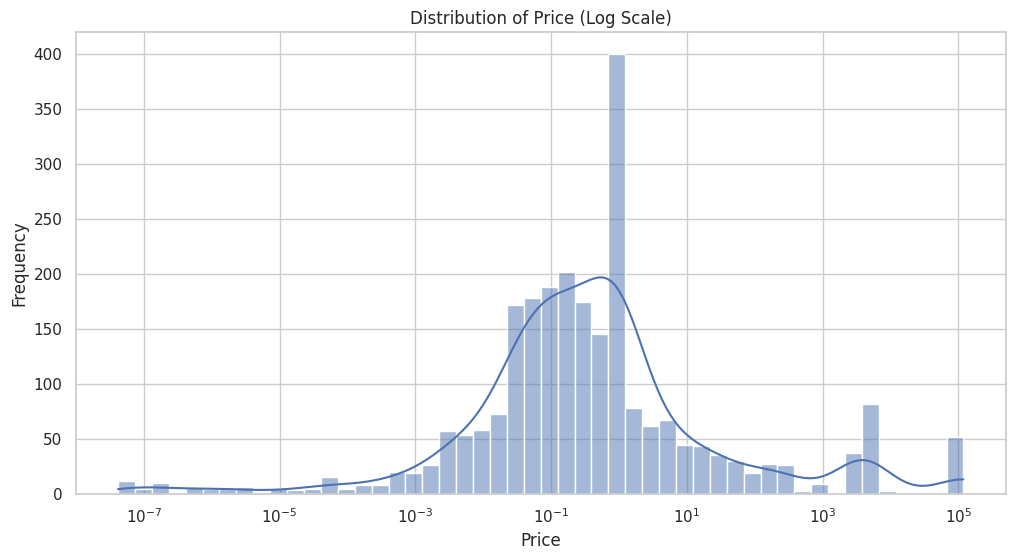

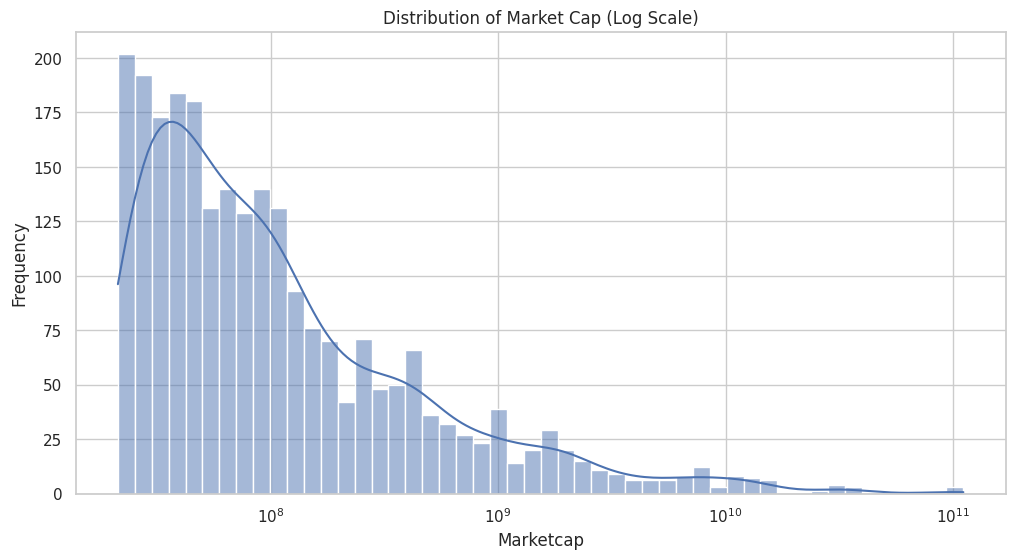

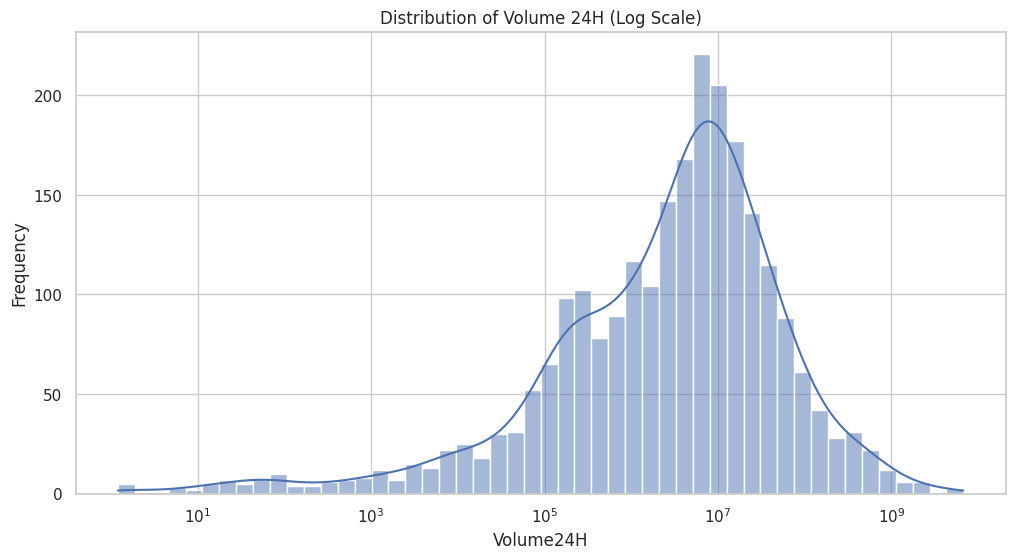

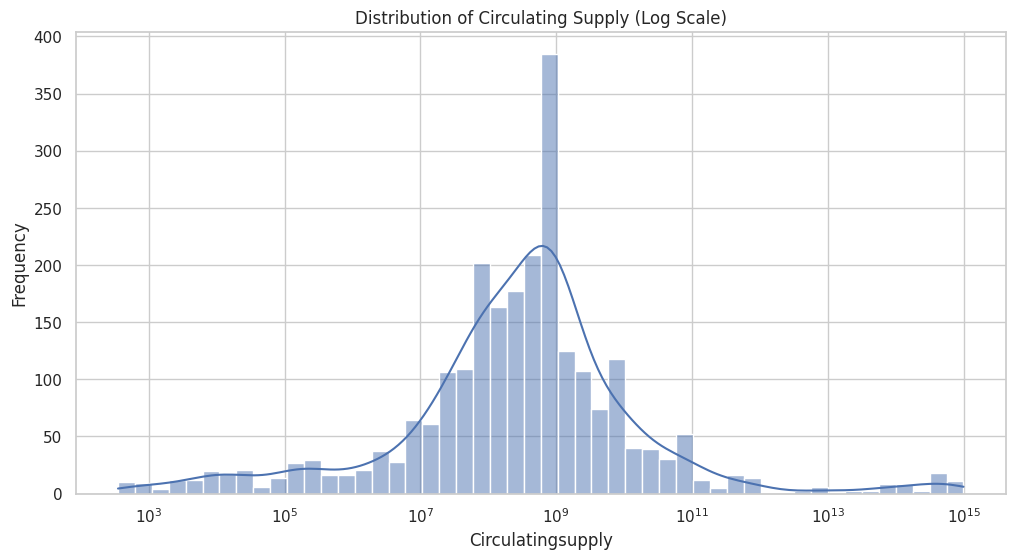

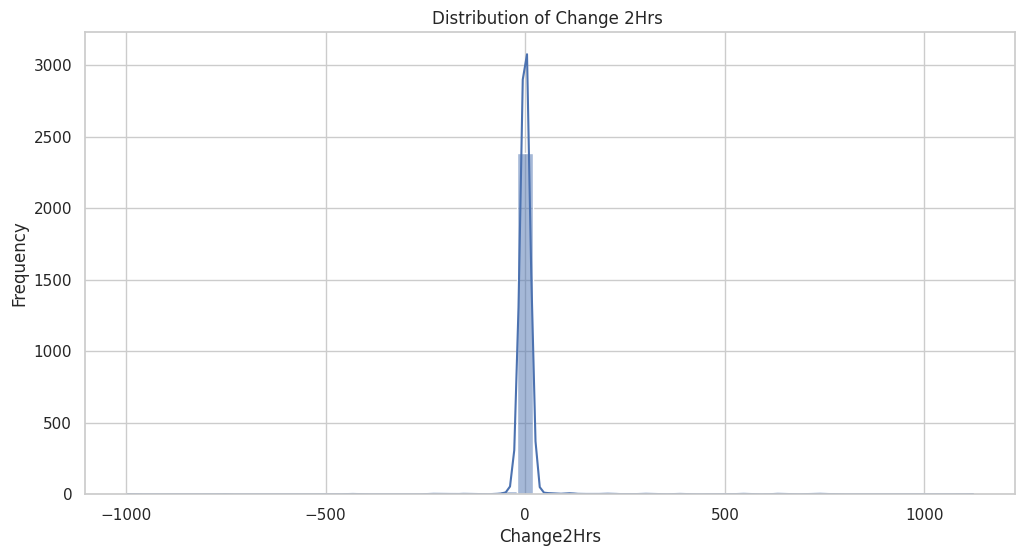

In [14]:
sns.set(style = 'whitegrid')
plt.figure(figsize=(14,6))

# Helper function for plotting

def plot_distribution(data, column, log = False):
    clean_data = data[column].replace([np.inf, -np.inf], np.nan).dropna()
    if log:
        clean_data = clean_data[clean_data > 0]  #remove 0 or negatives for log scale
        log_scale = True
    else:
        log_scale = False

    plt.figure(figsize=(12,6))
    sns.histplot(clean_data, bins = 50, kde = True, log_scale=log_scale)
    plt.title(f'Distribution of {column.replace("_", " ").title()} {"(Log Scale)" if log else ""}')
    plt.xlabel(column.replace('_', '').title())
    plt.ylabel('Frequency')
    plt.show()

# Plot each distribution
plot_distribution(df, 'price', log  = True)
plot_distribution(df, 'market_cap', log = True)
plot_distribution(df, 'volume_24h', log=True)
plot_distribution(df, 'circulating_supply', log=True)
plot_distribution(df, 'change_2hrs', log=False)  # No log scale for changes


These plots apply log scale where appropriate to handle extreme skewness

Histograms show the frequency distribution

KDE curves provide a smooth estimate of the distribution

Log scales make it easier to see wide-ranging values (e.g., price ranges from cents to tens of thousands)

## SECTION A: Price Drivers and Correlation

## 1.What is the pairwise correlation between price, market cap, volume_24h, and circulating_supply?


----Correlation Matrix----


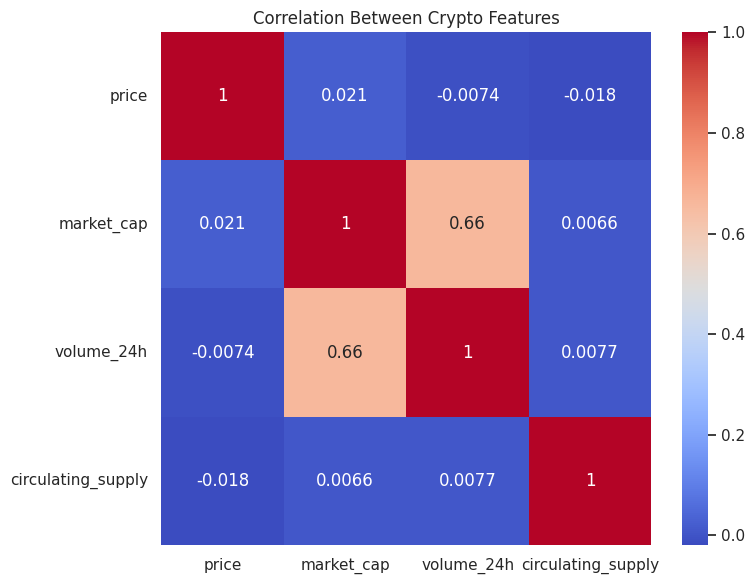

In [15]:
print('\n----Correlation Matrix----')

correlation = df[['price', 'market_cap', 'volume_24h', 'circulating_supply']].corr()
plt.figure(figsize = (8, 6))
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')
plt.title('Correlation Between Crypto Features')
plt.tight_layout()
plt.show()

## 2. Does higher trading volume associate with higher market capitalization?

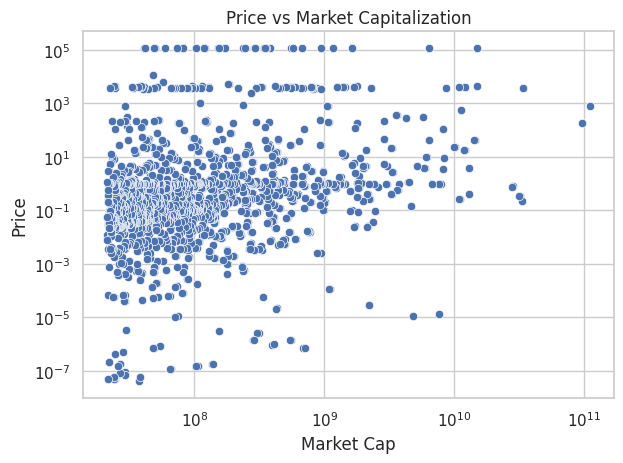

In [16]:
# Price vs Market Cap
# Explore if coins with active trading are also the most valuable

sns.scatterplot(data = df, x = 'market_cap', y = 'price')
plt.xscale('log')
plt.yscale('log')
plt.title('Price vs Market Capitalization')
plt.xlabel('Market Cap')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

## 3.How do coins with high supply compare in price to coins with low supply?

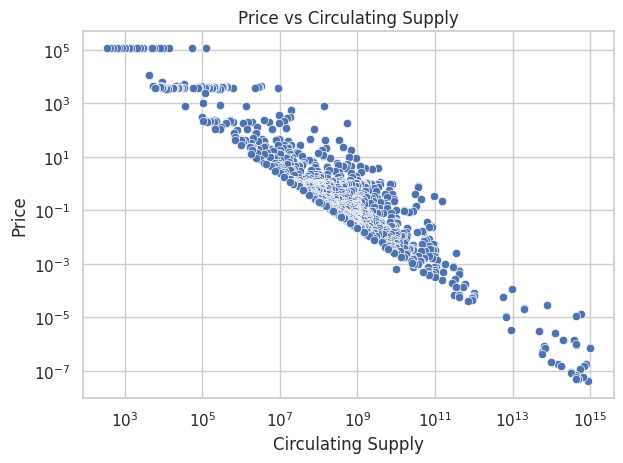

In [17]:
# Price vs Circulating Supply

sns.scatterplot(data = df, x = 'circulating_supply', y = 'price')
plt.xscale('log')
plt.yscale('log')
plt.title('Price vs Circulating Supply')
plt.xlabel('Circulating Supply')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

## 4.Are there visible outliers that violate typical supply-price expectations?

In [18]:
# Group by Coin to compute average price and average circulating supply

grouped = df.groupby('name')[['price', 'circulating_supply']].mean().reset_index()

In [19]:
# Adjust quantile thresholds to top / bottom 20%

price_high_20 = grouped['price'].quantile(0.80)
supply_high_20 = grouped['circulating_supply'].quantile(0.80)
price_low_20 = grouped['price'].quantile(0.20)
supply_low_20 = grouped['circulating_supply'].quantile(0.20)

In [20]:
# Identify new outliers with the stated thresholds

outliers_high_both_20 = grouped[
    (grouped['price'] > price_high_20) & (grouped['circulating_supply'] > supply_high_20)
]
outliers_low_both_20 = grouped[
    (grouped['price'] < price_low_20) & (grouped['circulating_supply'] < supply_low_20)
]

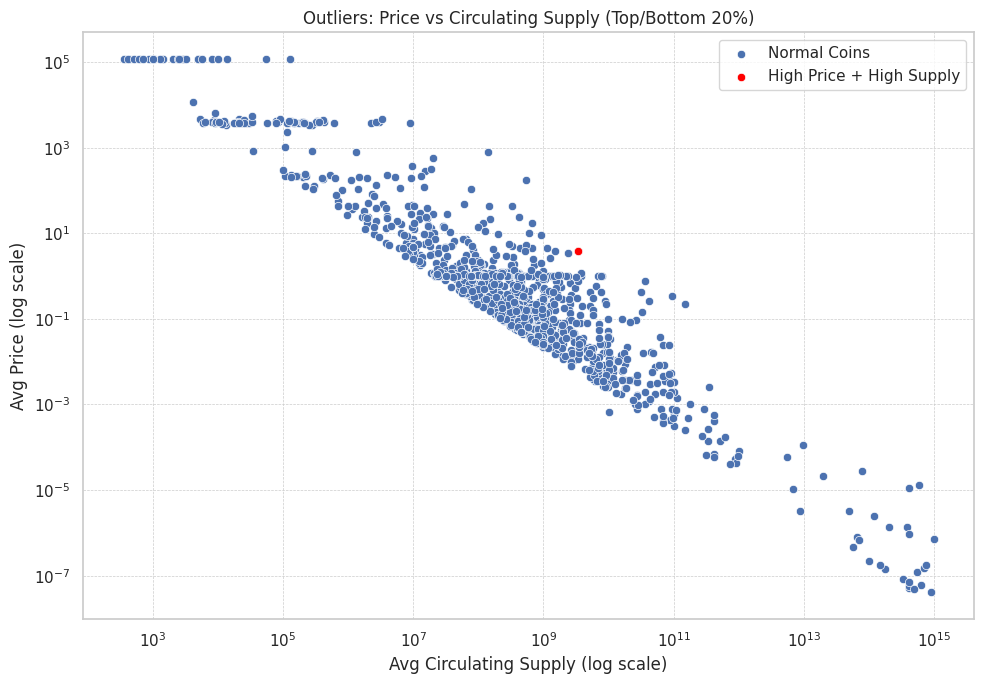

In [21]:
# Visualization with new outliers
plt.figure(figsize = (10, 7))
sns.scatterplot(data = grouped, x = 'circulating_supply', y = 'price', label = 'Normal Coins')
sns.scatterplot(data = outliers_high_both_20, x = 'circulating_supply', y = 'price', color = 'red', label = 'High Price + High Supply')
sns.scatterplot(data = outliers_low_both_20, x = 'circulating_supply', y = 'price', color = 'purple', label = 'Low Price + Low Supply')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Avg Circulating Supply (log scale)')
plt.ylabel('Avg Price (log scale)')
plt.title('Outliers: Price vs Circulating Supply (Top/Bottom 20%)')
plt.legend()
plt.tight_layout()
plt.grid(True, which = 'both', ls = '--', linewidth = 0.5)
plt.show()

In [22]:
# Output new outlier data
outliers_high_both_20, outliers_low_both_20

(    name  price  circulating_supply
 971  Sui   3.78        3.455015e+09,
 Empty DataFrame
 Columns: [name, price, circulating_supply]
 Index: [])

📈 High Price + High Supply Outliers

These coins violate the expected inverse supply-price logic:
Coin	Avg Price (USD)	  Avg Circulating Supply
Sui	  -- 3.68	            --   3.47 Billion
XRP	  -- 3.04	            --  59.25 Billion



--These are unusual because they manage to retain high prices despite a very large supply, possibly due to strong utility, branding, or network effects.

 ## B. Temporal and Volatility Analysis

## 1. What is the average price volatility for each coin over time?

In [23]:
# Volatility: Std Dev of price per coin

volatility = df.groupby('name')['price'].std().sort_values(ascending = False).head(100)
print('\nTop 100 Most Volatile Coins:')
print(volatility)


Top 100 Most Volatile Coins:
name
Zenrock BTC                           793.373808
aBTC                                  544.472222
Solv Protocol SolvBTC.CORE            535.279833
Avalanche Bridged WBTC (Avalanche)    519.723484
Sui Bridged WBTC (Sui)                500.631601
                                         ...    
Ankr Staked ETH                         1.442498
Bybit Staked SOL                        1.428356
Binance Staked SOL                      1.421285
Gnosis                                  1.385929
Jupiter Staked SOL                      1.371787
Name: price, Length: 100, dtype: float64


## 2. Which coins have the most consistent (stable) vs. volatile price movements?

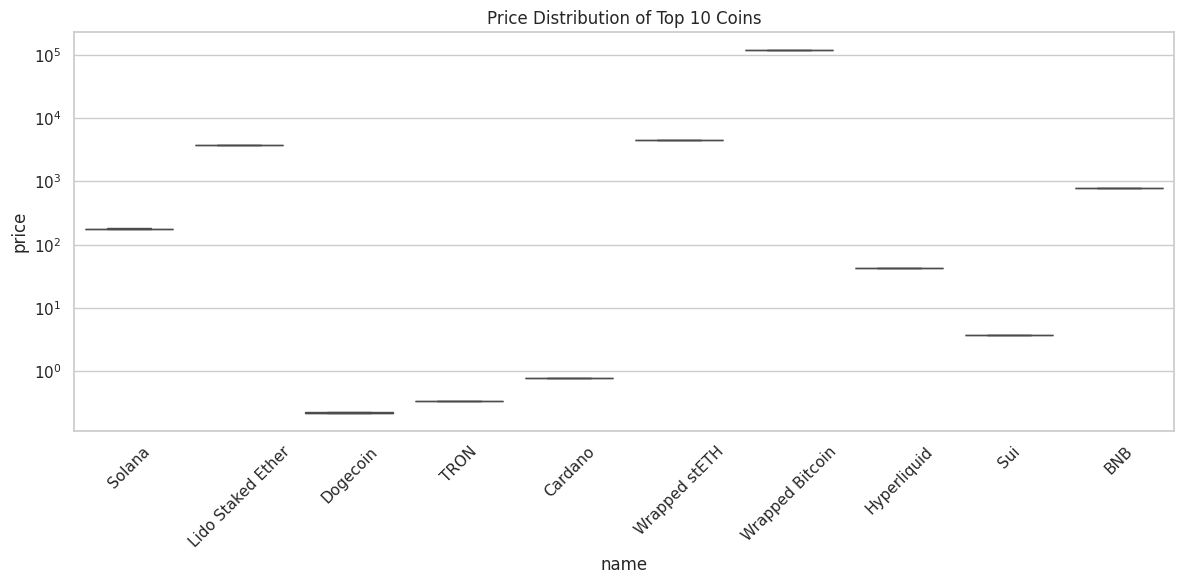

In [24]:
# Boxplot for price distributions
top_10 = df.groupby('name')['market_cap'].mean().sort_values(ascending = False).head(10).index
plt.figure(figsize = (12, 6))
sns.boxplot(data = df[df['name'].isin(top_10)], x = 'name', y = 'price')
plt.yscale('log')
plt.title('Price Distribution of Top 10 Coins')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


## 3. How does average trading volume and market cap change over the day (hourly trend)?

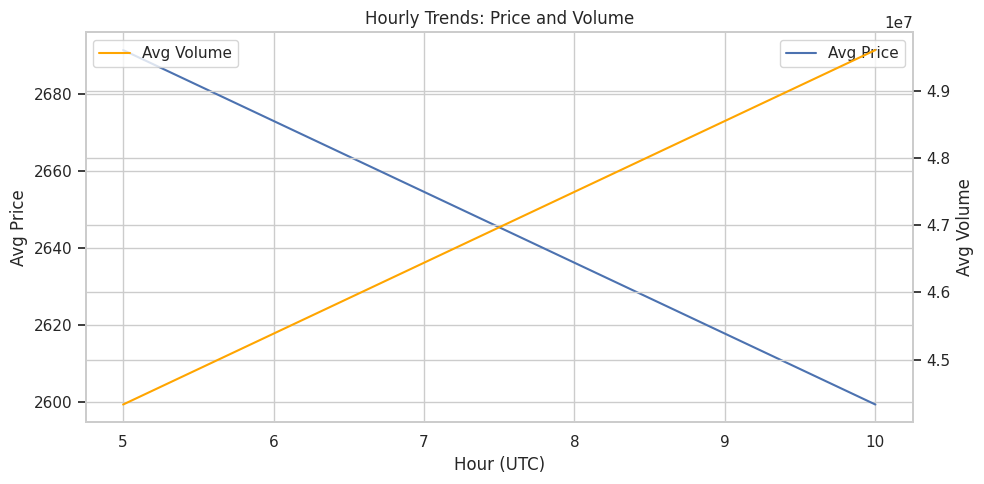

In [25]:
# Hourly activity trends
hourly_avg = df.groupby('hour')[['price', 'volume_24h']].mean()
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=hourly_avg['price'], label='Avg Price', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=hourly_avg['volume_24h'], label='Avg Volume', ax=ax2, color='orange')

ax1.set_xlabel("Hour (UTC)")
ax1.set_ylabel("Avg Price")
ax2.set_ylabel("Avg Volume")
plt.title("Hourly Trends: Price and Volume")
plt.tight_layout()
plt.show()

## 4. Do price spikes cluster at certain times (e.g., UTC hours or day boundaries)?

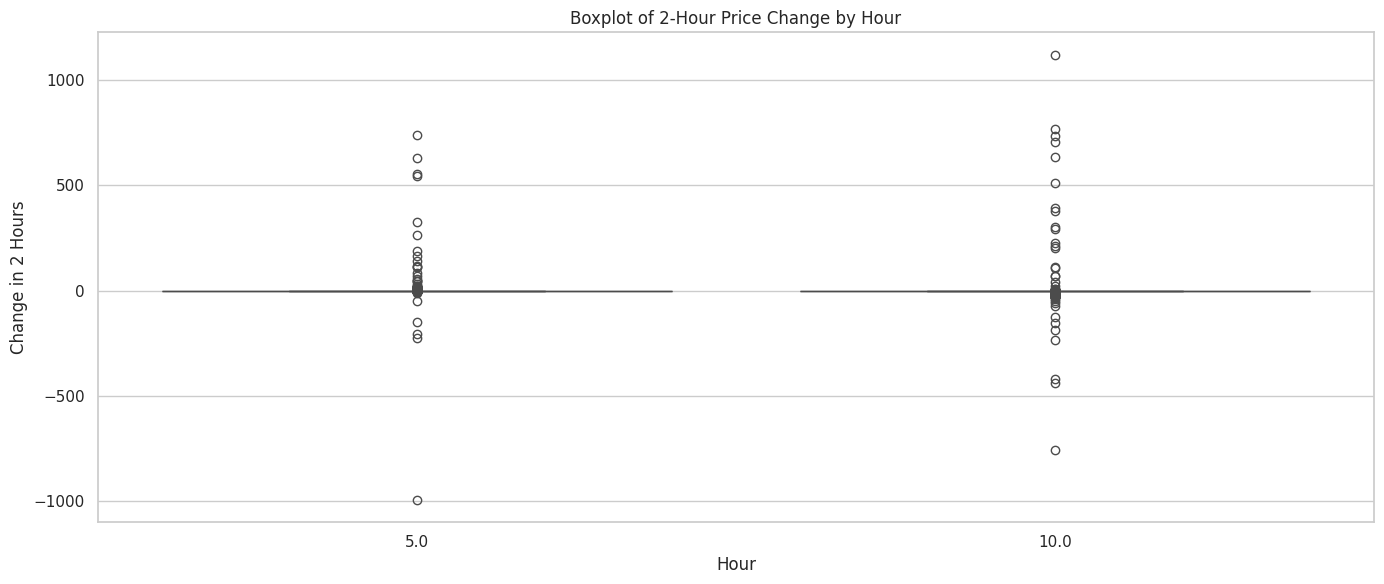

/tmp/ipykernel_25705/1805133077.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data = df, x = 'hour', y = 'change_2hrs', inner = 'quartile', scale = 'width')


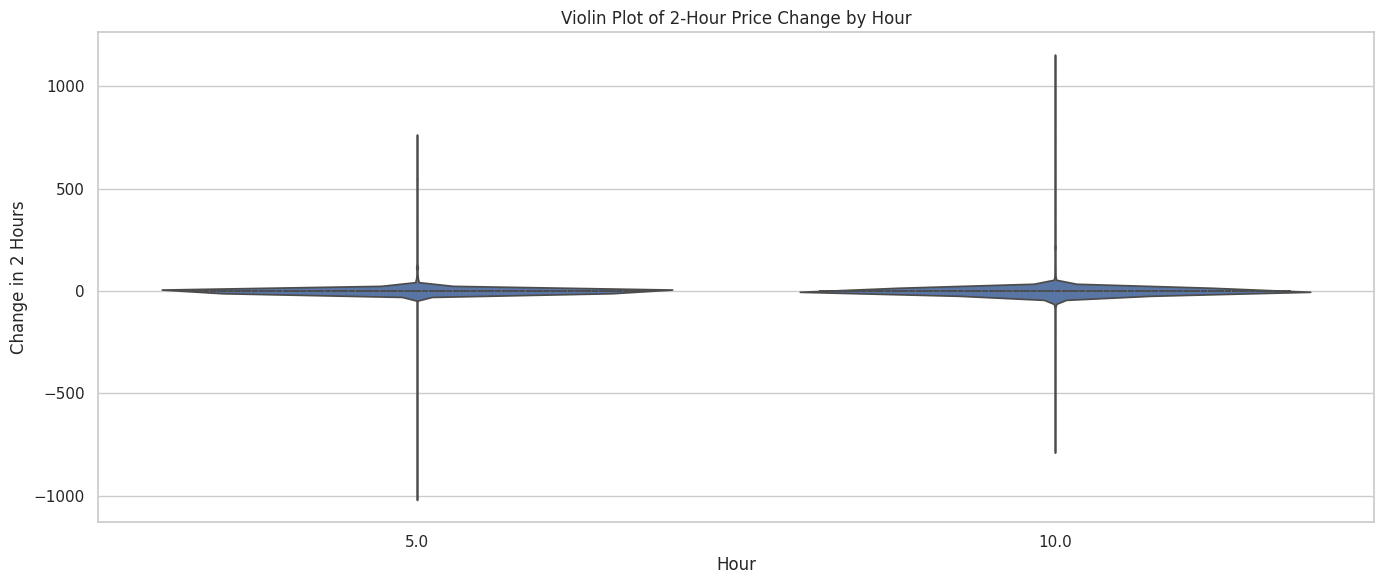

In [26]:
 #  Boxplot of change_2hrs by hour
plt.figure(figsize = (14, 6))
sns.boxplot(data = df, x = 'hour', y = 'change_2hrs')
plt.title('Boxplot of 2-Hour Price Change by Hour')
plt.xlabel('Hour')
plt.ylabel('Change in 2 Hours')
plt.tight_layout()
plt.show()

    # Violin plot of change_2hrs by hour 
plt.figure(figsize = (14, 6))
sns.violinplot(data = df, x = 'hour', y = 'change_2hrs', inner = 'quartile', scale = 'width')
plt.title('Violin Plot of 2-Hour Price Change by Hour')
plt.xlabel('Hour')
plt.ylabel('Change in 2 Hours')
plt.tight_layout()
plt.show()

## 5. Analysis of 2-Hour Price Change by Coin Name

In [27]:
 # Select top 12 coins by average market cap for clarity
top_coins = df.groupby('name')['market_cap'].mean().sort_values(ascending = False).head(12).index
df_top = df[df['name'].isin(top_coins)]

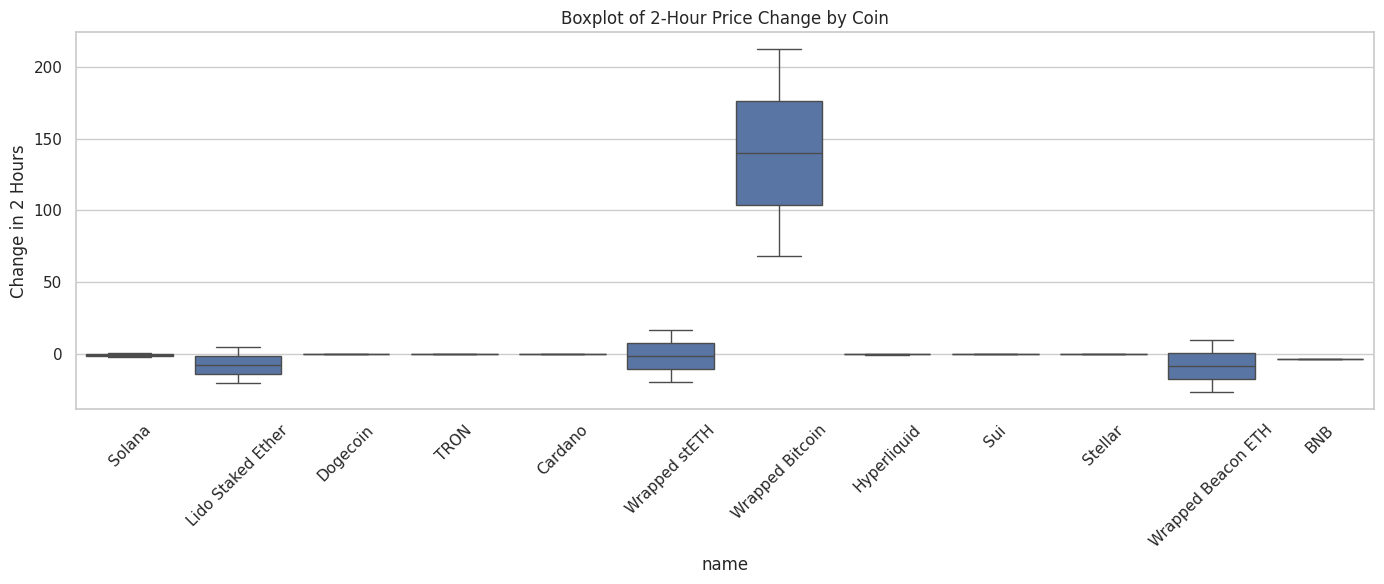

In [29]:
 # Boxplot
plt.figure(figsize = (14, 6))
sns.boxplot(data = df_top, x = 'name', y = 'change_2hrs')
plt.title('Boxplot of 2-Hour Price Change by Coin')
plt.xticks(rotation = 45)
plt.ylabel('Change in 2 Hours')
plt.tight_layout()
plt.show()

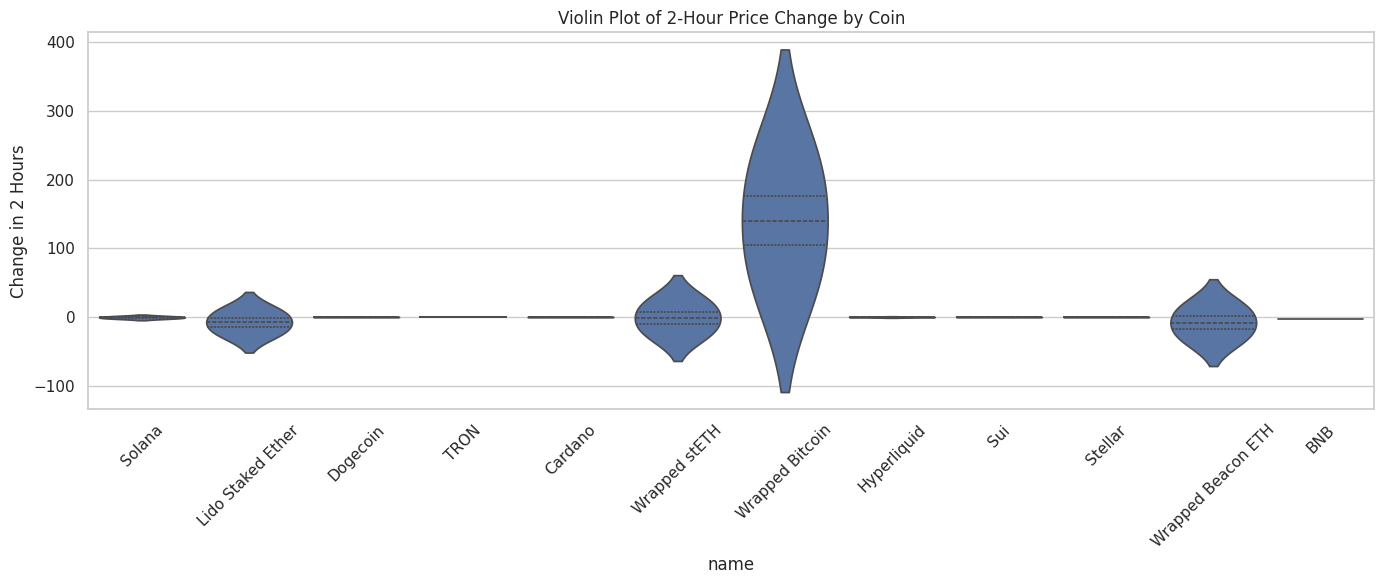

In [30]:
 # Violin Plot

plt.figure(figsize = (14, 6))
sns.violinplot(data = df_top, x = 'name', y = 'change_2hrs', inner = 'quartile', density_norm = 'width')
plt.title('Violin Plot of 2-Hour Price Change by Coin')
plt.xticks(rotation = 45)
plt.ylabel('Change in 2 Hours')
plt.tight_layout()
plt.show()

In [31]:
  #Summary Statistics 
coin_stats = df.groupby('name')['change_2hrs'].agg(['mean', 'std', 'min', 'max']).sort_values(by = 'std', ascending =False)
coin_stats.head(10)

,mean,std,min,max
name,,,,
Zenrock BTC,63.0,1497.652163,-996.0,1122.0
Solv Protocol SolvBTC.CORE,-8.5,1058.538851,-757.0,740.0
Chain-key Bitcoin,95.0,759.432683,-442.0,632.0
aBTC,282.0,690.136218,-206.0,770.0
Ether.fi Staked BTC,60.5,682.358044,-422.0,543.0
Cronos Bridged WBTC (Cronos),206.0,608.111832,-224.0,636.0
Avalanche Bridged WBTC (Avalanche),384.0,496.388960,33.0,735.0
Rings scBTC,266.5,403.757972,-19.0,552.0
Avalanche Bridged BTC (Avalanche),283.0,321.026479,56.0,510.0


## 6.Correlation of change_2hrs with volume_24h 

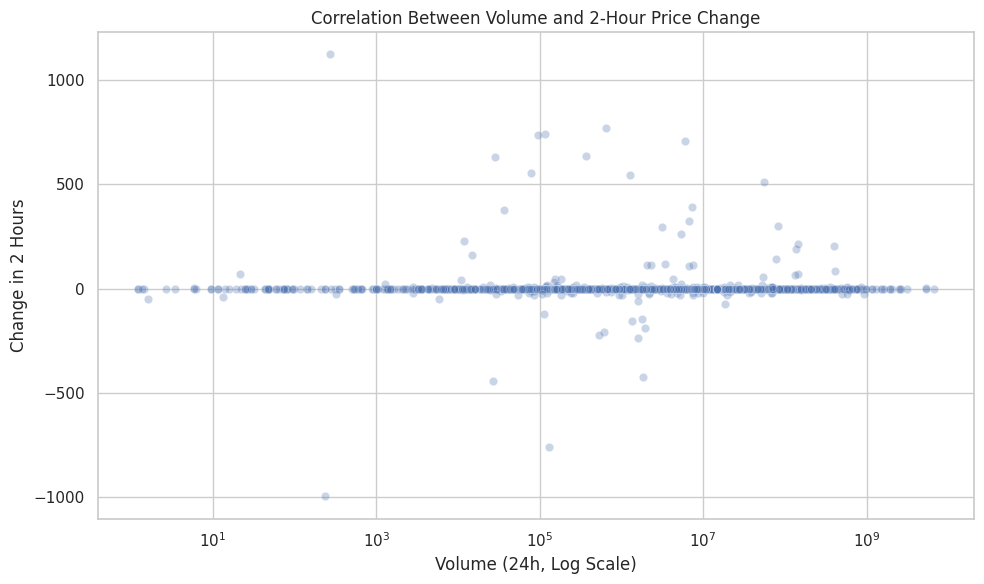


📈 Correlation between change_2hrs and volume_24h: -0.0022


In [32]:
# Scatterplot
plt.figure(figsize = (10, 6))
sns.scatterplot(data = df, x = 'volume_24h', y = 'change_2hrs', alpha = 0.3)
plt.xscale('log')
plt.title('Correlation Between Volume and 2-Hour Price Change')
plt.xlabel('Volume (24h, Log Scale)')
plt.ylabel('Change in 2 Hours')
plt.tight_layout()
plt.show()

# Correlation coefficient
corr_value = df[['change_2hrs', 'volume_24h']].corr().iloc[0, 1]
print(f'\n📈 Correlation between change_2hrs and volume_24h: {corr_value:.4f}')

## 7.Detect Extreme Outliers in change_2hrs

In [34]:
from scipy.stats import zscore

df['z_change_2hrs'] = zscore(df['change_2hrs'].fillna(0))
outliers = df[abs(df['z_change_2hrs']) > 3]

    
print(f"\n--- Detected {len(outliers)} Extreme 2-Hour Change Outliers (|Z| > 3) ---")
print(outliers[['timestamp', 'name', 'price', 'change_2hrs', 'z_change_2hrs']].sort_values(by = 'z_change_2hrs', ascending=False).head(10))

    


--- Detected 28 Extreme 2-Hour Change Outliers (|Z| > 3) ---
                      timestamp                                name     price  \
2946 2025-07-30 10:57:22.485891                         Zenrock BTC  118315.0   
2763 2025-07-30 10:57:22.485891                                aBTC  118287.0   
1835 2025-07-30 05:49:08.123578          Solv Protocol SolvBTC.CORE  117523.0   
3289 2025-07-30 10:57:22.485891  Avalanche Bridged WBTC (Avalanche)  118122.0   
2878 2025-07-30 10:57:22.485891              Sui Bridged WBTC (Sui)  118554.0   
3216 2025-07-30 10:57:22.485891        Cronos Bridged WBTC (Cronos)  118585.0   
2043 2025-07-30 05:49:08.123578                   Chain-key Bitcoin  117661.0   
1885 2025-07-30 05:49:08.123578                         Rings scBTC  117872.0   
1480 2025-07-30 05:49:08.123578                 Ether.fi Staked BTC  117777.0   
2661 2025-07-30 10:57:22.485891   Avalanche Bridged BTC (Avalanche)  118389.0   

      change_2hrs  z_change_2hrs  
2946       

## 8.Are there trends in average 2-hour price change over time globally?

In [37]:
# Set time granularity(daily average)

df['date'] = df['timestamp'].dt.date

# Group by date, compute mean of 2-hour change across all coins

daily_change = df.groupby('date')['change_2hrs'].mean()
daily_change

date
2025-07-30    2.571705
Name: change_2hrs, dtype: float64

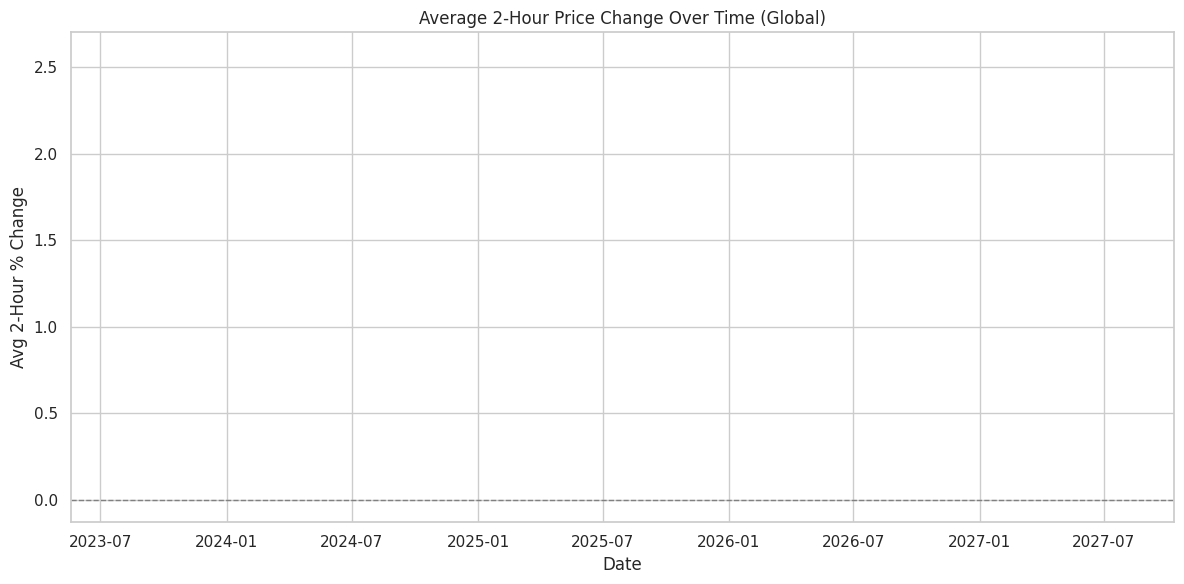

In [38]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = daily_change)
plt.title('Average 2-Hour Price Change Over Time (Global)')
plt.xlabel('Date')
plt.ylabel('Avg 2-Hour % Change')
plt.axhline(0, color = 'gray', linestyle = '--', linewidth = 1)
plt.tight_layout()
plt.show()

## Section C: Supply and Market Dynamics

## 1.How does market cap influence price volatility?

/tmp/ipykernel_25705/4197172742.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_per_bin = df.groupby('market_cap_bin')['price'].std()


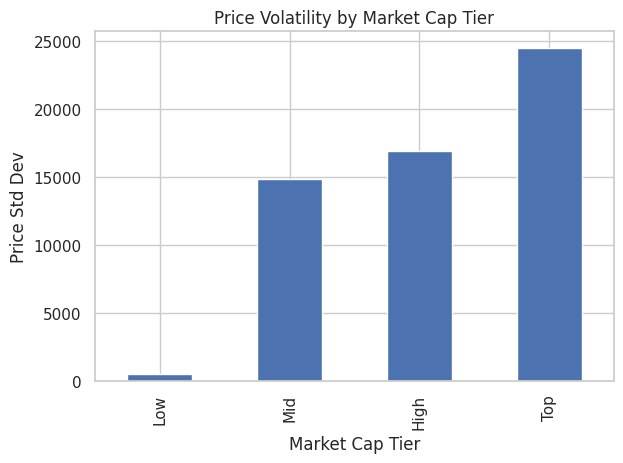

In [39]:
# Price volatility vs Market Capitalization
df['market_cap_bin'] = pd.qcut(df['market_cap'], 4, labels = ['Low', 'Mid', 'High', 'Top'])
vol_per_bin = df.groupby('market_cap_bin')['price'].std()
vol_per_bin.plot(kind = 'bar', title = 'Price Volatility by Market Cap Tier')
plt.xlabel('Market Cap Tier')
plt.ylabel('Price Std Dev')
plt.tight_layout()
plt.show()

## 2.What is the typical price range for coins in different supply ranges?

/tmp/ipykernel_25705/3098735003.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_per_supply = df.groupby('supply_bin')['price'].mean()


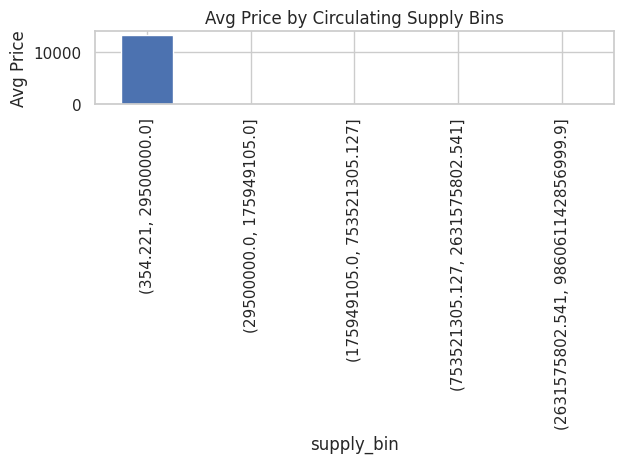

In [40]:
# Price by supply bin
df['supply_bin'] = pd.qcut(df['circulating_supply'], 5)
avg_price_per_supply = df.groupby('supply_bin')['price'].mean()
avg_price_per_supply.plot(kind = 'bar', title = 'Avg Price by Circulating Supply Bins')
plt.ylabel('Avg Price')
plt.tight_layout()
plt.show()


## 3.Average change_2hrs by coin

In [41]:
avg_change = df.groupby('name')['change_2hrs'].mean().sort_values(ascending=False)
print('\nTop Movers by Avg 2-Hour Change:')
print(avg_change.head(10))


Top Movers by Avg 2-Hour Change:
name
Sui Bridged WBTC (Sui)                516.0
Avalanche Bridged WBTC (Avalanche)    384.0
Avalanche Bridged BTC (Avalanche)     283.0
aBTC                                  282.0
Lorenzo stBTC                         269.5
Rings scBTC                           266.5
Polygon Bridged WBTC (Polygon POS)    253.0
Unit Bitcoin                          222.0
Cronos Bridged WBTC (Cronos)          206.0
Lombard Staked BTC                    185.0
Name: change_2hrs, dtype: float64


## 4.Coins with highest avg price

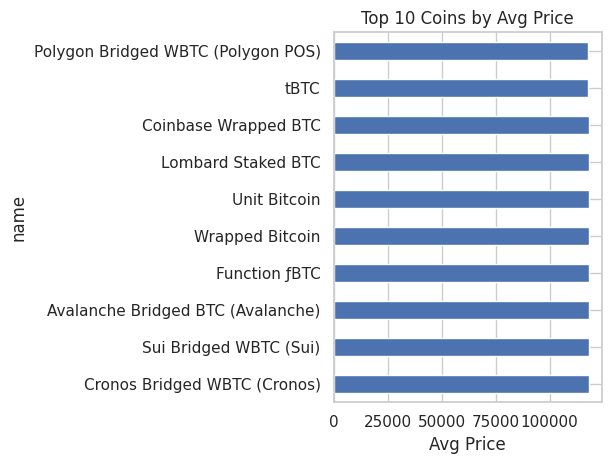

In [42]:
top_price = df.groupby('name')['price'].mean().sort_values(ascending=False).head(10)
top_price.plot(kind='barh', title='Top 10 Coins by Avg Price')
plt.xlabel("Avg Price")
plt.tight_layout()
plt.show()

## 5.Coins with highest avg volume

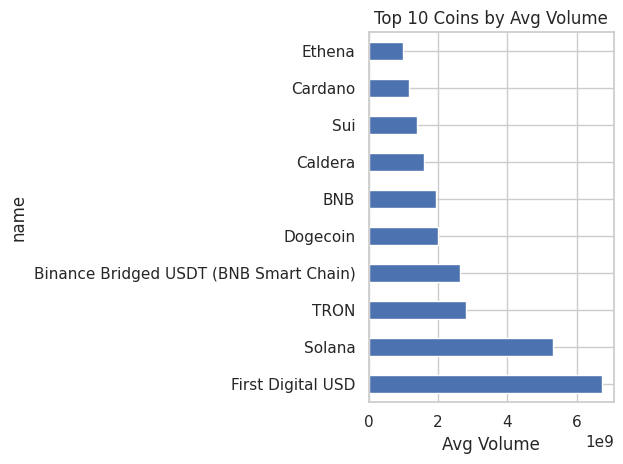

In [43]:
top_volume = df.groupby('name')['volume_24h'].mean().sort_values(ascending=False).head(10)
top_volume.plot(kind='barh', title='Top 10 Coins by Avg Volume')
plt.xlabel("Avg Volume")
plt.tight_layout()
plt.show()

## 6.Detect coins with largest 2hr changes (positive/negative extremes)

In [44]:
valid_changes = df.dropna(subset = ['change_2hrs'])

In [45]:
# Top 10 positive 2hr changes
top_gainers = valid_changes.sort_values(by = 'change_2hrs', ascending = False).head(10)
print('\n🔼 Top 10 Largest Positive 2-Hour Changes:')
print(top_gainers[['timestamp', 'name', 'change_2hrs']])


🔼 Top 10 Largest Positive 2-Hour Changes:
                      timestamp                                name  \
2946 2025-07-30 10:57:22.485891                         Zenrock BTC   
2763 2025-07-30 10:57:22.485891                                aBTC   
1835 2025-07-30 05:49:08.123578          Solv Protocol SolvBTC.CORE   
3289 2025-07-30 10:57:22.485891  Avalanche Bridged WBTC (Avalanche)   
2878 2025-07-30 10:57:22.485891              Sui Bridged WBTC (Sui)   
3216 2025-07-30 10:57:22.485891        Cronos Bridged WBTC (Cronos)   
2043 2025-07-30 05:49:08.123578                   Chain-key Bitcoin   
1885 2025-07-30 05:49:08.123578                         Rings scBTC   
1480 2025-07-30 05:49:08.123578                 Ether.fi Staked BTC   
2661 2025-07-30 10:57:22.485891   Avalanche Bridged BTC (Avalanche)   

      change_2hrs  
2946       1122.0  
2763        770.0  
1835        740.0  
3289        735.0  
2878        708.0  
3216        636.0  
2043        632.0  
1885        552

In [46]:
# Top 10 negative 2hr changes
top_losers = valid_changes.sort_values(by = 'change_2hrs', ascending = True).head(10)
print('\n🔽 Top 10 Largest Negative 2-Hour Changes:')
print(top_losers[['timestamp', 'name', 'change_2hrs']])


🔽 Top 10 Largest Negative 2-Hour Changes:
                      timestamp                          name  change_2hrs
1690 2025-07-30 05:49:08.123578                   Zenrock BTC       -996.0
3090 2025-07-30 10:57:22.485891    Solv Protocol SolvBTC.CORE       -757.0
3300 2025-07-30 10:57:22.485891             Chain-key Bitcoin       -442.0
2737 2025-07-30 10:57:22.485891           Ether.fi Staked BTC       -422.0
2794 2025-07-30 10:57:22.485891                 Universal BTC       -235.0
1962 2025-07-30 05:49:08.123578  Cronos Bridged WBTC (Cronos)       -224.0
1508 2025-07-30 05:49:08.123578                          aBTC       -206.0
2605 2025-07-30 10:57:22.485891             Solv Protocol BTC       -187.0
2854 2025-07-30 10:57:22.485891                 Function ƒBTC       -155.0
1547 2025-07-30 05:49:08.123578                 Universal BTC       -148.0


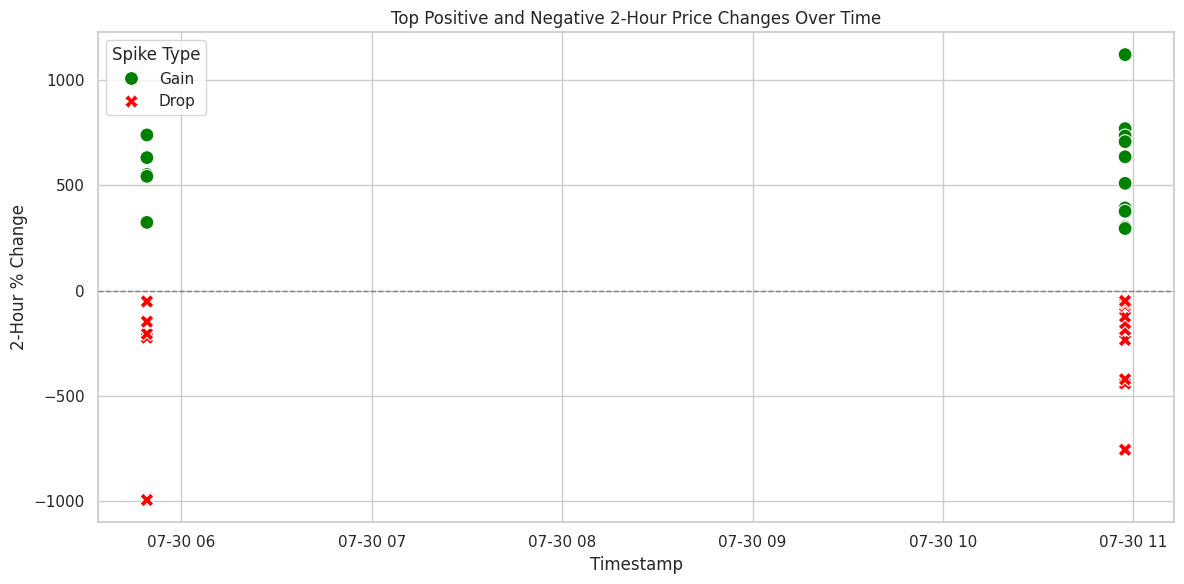

In [47]:
# Scatterplot of Top 2-Hour Spikes (Up & Down) Over Time
# Define extremes
top_n = 15
valid_changes = df.dropna(subset=['change_2hrs'])

# Top N spikes (positive and negative)
extremes = pd.concat([
    valid_changes.nlargest(top_n, 'change_2hrs'),
    valid_changes.nsmallest(top_n, 'change_2hrs')
])

# Set color based on direction
extremes['spike_type'] = extremes['change_2hrs'].apply(lambda x: 'Gain' if x > 0 else 'Drop')

# Plot
plt.figure(figsize = (12, 6))
sns.scatterplot(
    data = extremes,
    x = 'timestamp',
    y = 'change_2hrs',
    hue = 'spike_type',
    palette = {'Gain': 'green', 'Drop': 'red'},
    s = 100,
    style = 'spike_type'
)
plt.title('Top Positive and Negative 2-Hour Price Changes Over Time')
plt.xlabel('Timestamp')
plt.ylabel('2-Hour % Change')
plt.axhline(0, color = 'gray', linestyle = '--', linewidth = 1)
plt.legend(title="Spike Type")
plt.tight_layout()
plt.show()

## 7.Is there a lag between volume surge and price movement?

In [48]:
# Sort data for lagged analysis
df_sorted = df.sort_values(['name', 'timestamp'])

# Shift change_2hrs backward by 1 step within each coin
df_sorted['future_change_2hrs'] = df_sorted.groupby('name')['change_2hrs'].shift(-1)

# Drop missing
lagged_df = df_sorted.dropna(subset=['future_change_2hrs', 'volume_24h'])


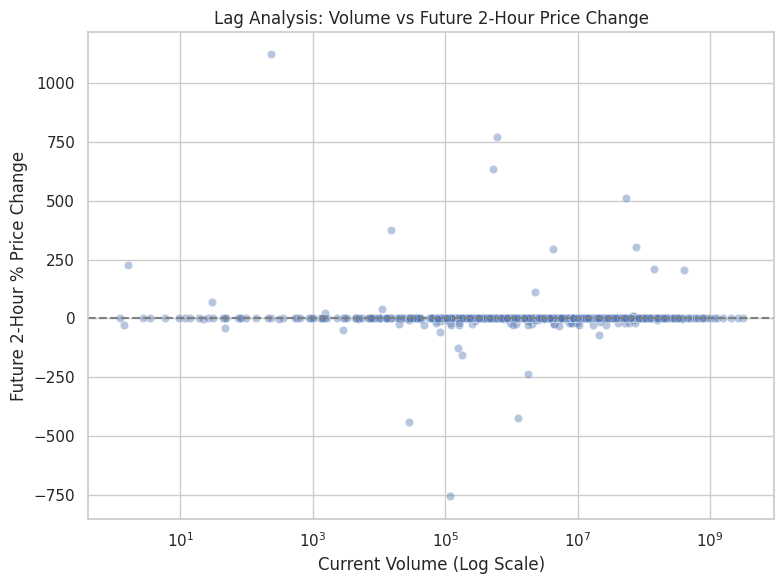

In [49]:
# Plot scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=lagged_df.sample(1000),  # sample to reduce overplot
    x='volume_24h',
    y='future_change_2hrs',
    alpha=0.4
)
plt.xscale('log')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Lag Analysis: Volume vs Future 2-Hour Price Change")
plt.xlabel("Current Volume (Log Scale)")
plt.ylabel("Future 2-Hour % Price Change")
plt.tight_layout()
plt.show()

In [50]:
# Print correlation
corr = lagged_df['volume_24h'].corr(lagged_df['future_change_2hrs'])
print(f"\n🔁 Correlation between Current Volume and Future 2-Hour Change: {corr:.4f}")


🔁 Correlation between Current Volume and Future 2-Hour Change: -0.0018
